In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy
from scipy import stats

import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet

errors = {}

In [4]:
CONFIG = {
    'validation_window': {
        'min_window': 13,
        'max_window': 32,
    },
    'training_window': {
        'min': 16
    },
    'FETCH_DATA': True,
    'dataset_paths': {
        'train': 'extracted_features.csv',
        'task_df': 'full_dataset.csv',
        'idx': 'idx.csv',
        'extended': 'extended_full_dataset.csv'
    }
}

### Dataset fetching

In [6]:
task_df = {}

task_df['test'] = pd.read_csv(CONFIG['dataset_paths']['task_df']).drop('Unnamed: 0', axis=1)
task_df['extended'] = pd.read_csv(CONFIG['dataset_paths']['extended']).drop('Unnamed: 0', axis=1)
train = pd.read_csv(CONFIG['dataset_paths']['train']).drop('Unnamed: 0', axis=1)
idx = pd.read_csv(CONFIG['dataset_paths']['idx']).drop('Unnamed: 0', axis=1)
target_test = task_df['test'].rename(columns={'month_block': 'window', 'item_cnt_month': 'target'})

In [8]:
from sklearn.metrics import mean_squared_error as mse

def get_features(date, train_df):
    return train_df[train_df.window == date].set_index(['id', 'window']).sort_index().drop('index', axis=1)
        
def get_target(date, target_vector):
    return target_vector.reset_index()[target_vector.reset_index().window == date].set_index(['id', 'window']).sort_index().drop('index', axis=1)

class RegressionValidator__transform:
    """
        Hardcoded for a while
    """
    def __init__(self, model, transform, back_transform,*args, **kwargs):
        self.model = model(**kwargs)
        self._transform = back_transform
        self._f_transform = transform
        
    def validate(self, cfg, joined_dataset, test_target):
        """
            Validate selected model on a dataset

            Input:

            1) 'joined_dataset' has the following format: ['id', 'window', feature_1, ... , target]
            2) 'test_target': ['id', 'window', 'target']
            3) 'cfg' is a dictionary containig ('min_window', 'max_window') in keys


            Out:
                - Residual statistics
        """
        train_df = joined_dataset.drop(['target'], axis=1)
        target_vector = joined_dataset.loc[:, ['id', 'window', 'target']]
        
        def get_features(date):
            return train_df[train_df.window == date].set_index(['id', 'window']).sort_index()
        
        current_date = cfg['min_window']
        max_date = cfg['max_window']
        
        errors = [
            [], [], [], []
        ]
        
        while current_date < max_date:
            current_features = get_features(current_date)
            validation_window = get_features(current_date + 1)
            
            current_target = get_target(current_date, target_vector)
            validation_target = get_target(current_date + 1, test_target)

            fitted = self.model.fit(current_features, current_target)

            tr_predictions = self.model.predict(validation_window)
            
            predictions = self._transform(tr_predictions)

            if predictions.transpose().shape[0] == 1:
                predictions = predictions.transpose()[0]
            else:
                predictions = predictions.transpose()
        
            errors[0].append(current_date)
            assert validation_target.loc[:,'target'].shape == predictions.shape, f'Shapes are pred:{validation_target.loc[:,"target"].shape} and truth:{predictions.shape}\nCurrent validation set: {current_date}'
            errors[1].append(mse(validation_target.loc[:,'target'].to_list(), predictions))
            
            report = pd.DataFrame({'true_values': validation_target.loc[:,'target'].to_list(), 'predicted': predictions})
            errors[2].append(report)
            inner_report = pd.DataFrame({'true_values': self._f_transform(validation_target.loc[:,'target'].to_numpy()), 'predicted': tr_predictions})
            errors[3].append(inner_report)
            
            current_date += 1
        
        return errors

In [9]:
def get_statistics(report):
    stat = report.copy()
    stat['residuals'] = stat['predicted'] - stat['true_values'] 
    stat['id'] = stat.index
    stat['abs_residuals'] = stat['residuals'].abs()
    stat['percentage'] = 2*(stat['residuals'])/(stat['true_values'] + stat['predicted'])
    return stat

def stat_info(errors):
    mean_residuals = pd.DataFrame({'abs_resid': [0 for _ in range(438)], 'resid': [0 for _ in range(438)]}, [i for i in range(438)])
    residual_series = None
    for _idx, report in enumerate(errors):
        residuals = get_statistics(report)
        mean_residuals['abs_resid'] += residuals['abs_residuals']
        mean_residuals['resid'] += residuals['residuals']
        resids = residuals['residuals'].reset_index()
        resids['window'] = _idx
        resids['true_value'] = residuals['true_values']
        resids.set_index(['index', 'window'], inplace=True)
        if residual_series is None:
            residual_series = resids
        else:
            residual_series = pd.concat([residual_series, resids])
    mean_residuals /= len(errors)
    return mean_residuals, residual_series, residuals

# Chapter 1
## Feature importance 

In [16]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

evaluation_forest = RandomForestRegressor(n_jobs=-1, max_depth=40)

In [17]:
split_last_x = train[train.window <= 32].drop(['target'], axis=1).set_index(['id', 'window'])
split_last_y = train[train.window <= 32].loc[:, ['id', 'window', 'target']].set_index(['id', 'window'])

In [18]:
feat_selector = BorutaPy(evaluation_forest, n_estimators='auto', verbose=0, random_state=1)

_ = feat_selector.fit(split_last_x.values, split_last_y.values)

split_last_x.columns[feat_selector.support_]

Index(['lag_2_mul', '_amin', 'last_12_mean', 'last_6_mean', 'last_2_mean',
       'last_observed'],
      dtype='object')

In [19]:
select = pd.DataFrame({'column_name': split_last_x.columns, 'importance': (feat_selector.ranking_)}).set_index('column_name').sort_values('importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='column_name'>

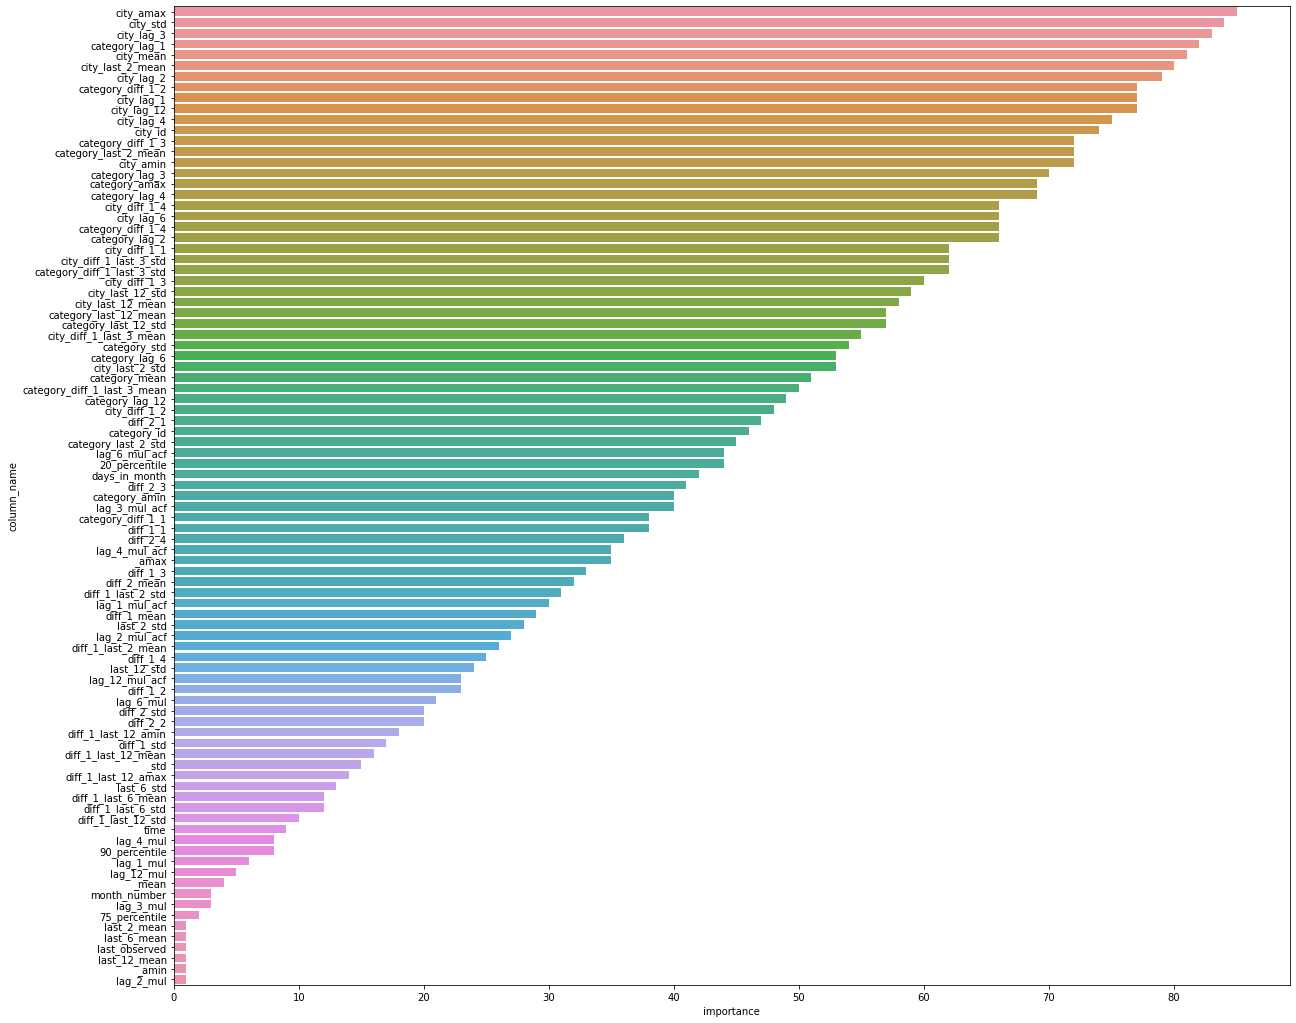

In [20]:
_, axs = plt.subplots(1, 1, figsize=(20, 18))

sns.barplot(data=select.reset_index(), x='importance', y='column_name', ax=axs)

# Chapter 2
## Evaluating feature minimum 

In [21]:
def gaussian_test(dataset):
    from scipy.stats import anderson

    result = anderson(dataset)

    print('stat=%.3f' % (result.statistic))
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            print('Probably not Gaussian at the %.1f%% level' % (sl))